# Pipeline 1: Google-To-DW pipeline

The aim of this notebook is to be able to answer the questions: Is DW covering what customers want

Approach: Extract trending topics on Google and compare to what DW covers

<img src="../reports/illustrations/pipeline1.png" width=800 />

We tried 2 different approaches:

**Approach 1**: we used pre-trained models such as Chat GPT and zero-shot learning. \
This approach was overal less effective. Our attempts can be found in pipeline2_playground_approach1_*.ipynb

**Approach 2**: we trained our own models \
The most performing models are sumarised here. Our other attempts can be found in pipeline2_playground_approach2.ipynb

<img src="../reports/illustrations/pipeline2_approaches.png" width=800 />

In [10]:
# Import useful libraries
import pandas as pd
import os
import sys
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
import fasttext
import seaborn as sns

# Import functions from source folder
sys.path.append('../src/') 
from data.preprocess_keywords import make_cleaned_keywords_df
from data.make_datasets import get_data, get_daily_trending_searches, save_txt
from features.build_features import get_vectors
from models.predict_model import prediction, run_predict_for_series
from visualization.visualize import count_values_for_columns

In [11]:
# Specify wanted time range
start_date = '2019-01-01'
end_date = '2019-02-01'

# Where data files will be stored
path_to_data_files = '../data/interim/'

# Extract trending topics from Google

In [3]:
# Extracts trending topic from Google if the file does not exist, else loads it
# If error with the number of requests, change the header in make_datasets.py 
# (https://stackoverflow.com/questions/50571317/pytrends-the-request-failed-google-returned-a-response-with-code-429#:~:text=I%20am%20trustworthy.-,Solution,Visit%20the%20Google%20Trend%20page%20and%20perform%20a%20search%20for,-a%20trend%3B%20it)

google_file = path_to_data_files + start_date + '_' + end_date + '_World_daily_trending_searches.json'

if os.path.isfile(google_file) == False:
    df_google = get_daily_trending_searches(path_to_data_files, start_date, end_date = end_date)
else:
    df_google = pd.read_json(google_file, orient ='split', compression = 'infer') 

# Load DW data

In [4]:
# Clean data file in specific date range
clean_data_file = '../data/interim/clean_keywords_' + start_date + '_' + end_date + '.json'

# Generates the clean data file if it does not exist
if os.path.isfile(clean_data_file) == False:

    # Path to raw data
    data_file = '../data/raw/CMS_2010_to_June_2022_ENGLISH.json'

    # Load and extract data within time range
    df_subset = get_data(data_file, start_date, end_date)

    # Cleans keywords and saves data as a dataframe
    make_cleaned_keywords_df(df_subset, start_date, end_date)


# Loads the clean data file
df_dw = pd.read_json(clean_data_file, orient ='split', compression = 'infer')

# Remove rows witn no category
df_dw.dropna(subset=['cleanFocusParentCategory'], inplace = True)
df_dw.reset_index(drop = True, inplace = True)

# Models: map google keywords to DW category

# Models with Word2vec

In [21]:
# Loads word2vec google model
wv = api.load('word2vec-google-news-300')

In [16]:
# Split in test and train
lst_keywords_train, lst_keywords_test, label_train, label_test, indices_train, indices_test = \
    train_test_split(df_dw['keywordStringsCleanAfterFuzz'], df_dw['cleanFocusParentCategory'], df_dw.index, test_size=0.33, random_state=0) 

# Vectorise to input to the model
vec_keywords_dw_train = get_vectors(lst_keywords_train.astype(str), wv)
vec_keywords_dw_test = get_vectors(lst_keywords_test.astype(str), wv)

# Create empty dictionaries to store each model's score
score = {}

In [19]:
# Dummy model (mean)
model = DummyClassifier(strategy='uniform')
model.fit(vec_keywords_dw_train.values, label_train.values)
y_pred = model.predict(vec_keywords_dw_test.values)
score['Chance'] = accuracy_score(label_test.values, y_pred)

# Dummy model (weighted mean)
model = DummyClassifier(strategy='stratified')
model.fit(vec_keywords_dw_train.values, label_train.values)
y_pred = model.predict(vec_keywords_dw_test.values)
score['Weighted chance'] = accuracy_score(label_test.values, y_pred)

# Linear SVC
model = LinearSVC(max_iter = 8000)
model.fit(vec_keywords_dw_train.values, label_train.values)
y_pred = model.predict(vec_keywords_dw_test.values)
score['Linear SVC'] = accuracy_score(label_test.values, y_pred)

# SVC with RBF
model = SVC(C=20, kernel='rbf')
model.fit(vec_keywords_dw_train.values, label_train.values)
y_pred = model.predict(vec_keywords_dw_test.values)
score['SVC with RBF'] = accuracy_score(label_test.values, y_pred)

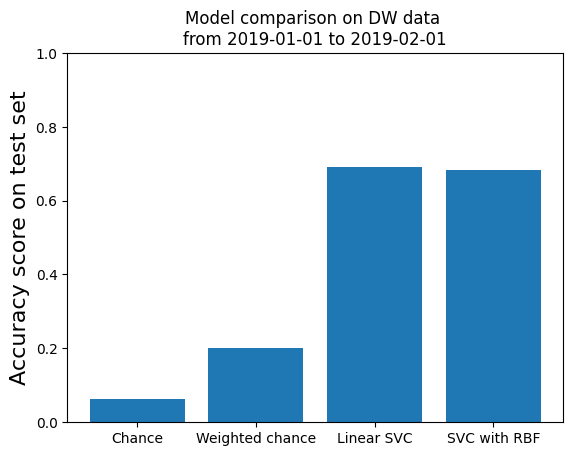

In [22]:
key, values = zip(*score.items())
plt.bar(key, values)
plt.ylabel('Accuracy score on test set', fontsize=16)
plt.ylim(0, 1)  
plt.title('Model comparison on DW data \nfrom ' + start_date + ' to ' + end_date)

plt.show()

# Model with FastText

In [20]:
# TODO add FastText accuracy on above plot

df_dw['cleanFocusParentCategory'] = df_dw['cleanFocusParentCategory'].apply(lambda x: x.replace(' ','-'))
df_clean_single_kw=df_dw.explode('keywordStringsCleanAfterFuzz')
label=df_dw['cleanFocusParentCategory'].apply(lambda x: ('__label__' +x+' '))
kw=df_dw['keywordStringsCleanAfterFuzz'].apply(lambda x: (', '.join(x)))
label_kw=label+kw

label_kw_train,label_kw_test = tts(label_kw, random_state=0, test_size=0.33)

all_kw_train=save_txt( path_to_data_files + 'fasttext/all_kw_train.txt',label_kw_train)
all_kw_test=save_txt( path_to_data_files + 'fasttext/all_kw_test.txt',label_kw_test)

model_all_kw_check = fasttext.train_supervised(input=all_kw_train, lr=1, epoch=12)

773it [00:00, 267972.31it/s]
381it [00:00, 63363.59it/s]
Read 0M words
Number of words:  2750
Number of labels: 20
Progress: 100.0% words/sec/thread:  258097 lr:  0.000000 avg.loss:  0.373681 ETA:   0h 0m 0s


# Run Models on Google data 
i.e., predict DW category from google data
e.g., with FastText model

In [15]:
# Predict categories for google searches topic title+type
google_data=df_google['topic_title']+' '+df_google['topic_type']

google_result=run_predict_for_series(model_all_kw_check, google_data) #topic title+type

# Plot

In [13]:
#count amount GS words for each category
#count_values_for_columns(google_result)[1]
data_g = count_values_for_columns(google_result)[1].values
labels_g = count_values_for_columns(google_result)[1].index

# make df with dw categories and extracted labels
single_kw_label=df_clean_single_kw['cleanFocusParentCategory'].apply(lambda x: ('__label__' +x+' '))
single_kw=df_clean_single_kw['keywordStringsCleanAfterFuzz']

new_labels = single_kw_label.str.split('__').apply(lambda row: row[2]).str.strip()

d={'dw_cat':new_labels,'dw_kw':single_kw}#,'pred_cat1','pred_cat2','pred_cat3','pred_cat4','pred_cat5'}
df_single=pd.DataFrame(data=d)

data_dw = count_values_for_columns(df_single)['dw_cat'].values
labels_dw = count_values_for_columns(df_single)['dw_cat'].index

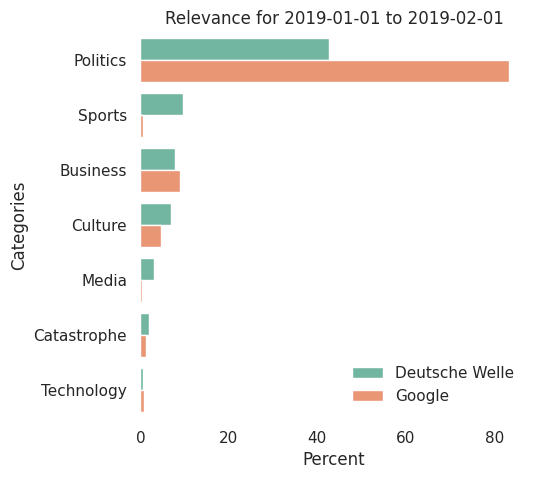

In [14]:
ds2 = pd.DataFrame({'Categories':labels_dw,'Percent':100*data_dw/data_dw.sum().round(1)})
ds1 = pd.DataFrame({'Categories':labels_g,'Percent':100*data_g/data_g.sum().round(1)})

ds2['source'] = 'Deutsche Welle'
ds1['source'] = 'Google'
dss = pd.concat([ds2, ds1])

subset_dss = dss[dss['Categories'].apply(lambda x: x in labels_g)]

#sns.barplot(x='Categories', y='Percent', hue='source', data=dss, palette='Set2')
sns.set(rc={'figure.figsize':(5,5), 'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(x='Percent', y='Categories', hue='source', data=subset_dss, palette='Set2')
sns.color_palette("deep")
plt.legend(loc='lower right',frameon=False)
plt.title('Relevance for ' + start_date + ' to ' + end_date)

plt.show()